# Integrated assessment model (IAM) Problem Set

# Macroeconomics I
# Professor: Marti Mestieri
# TA: Pothedar Sandeep Achary
# Submission by: Athanasios Kolokythas, Konstantinos Mira, Alberto Orts Torres

# Problem Set Questions:

# Question 1:

It turns out that I was being sloppy when writing my code. The way carbon taxes are introduced is not properly done in the market clearing equilibrium equation that is commented out, since the current code does not allow for them to be different across regions.

Your first task is to rewrite the function oil_mkt_clearing to allow for region-specific taxes. Please call this new function oil_mkt_clearing_tau.



# Question 2: What about Global Warming? 

One of the central goals of the IAMs is to predict on global warming. However, in its current version, the temperature does not appear as an output of our IAM. Which equations from our lecture notes would you use? Argue that we can write the temperature system as

$$𝑇_𝑡=𝑎_1𝑇_{𝑡−1}+𝑎_2𝑇_{𝐿t-1}+𝑎_3ln(\frac{𝑆_{𝑡−1}}{𝑆_0})$$

$$𝑇_{𝐿𝑡}=𝑏_1𝑇_{𝐿t-1}+𝑏_2𝑇_{𝑡−1}.$$

After showing this, think how you would code this module in the for loop (you will be asked to implement it below). Take the following parameter values from the HKO paper 𝜅=1.23
, 𝜂=3.7, 𝜎1=0.22. 𝜎2=0.3 and 𝜎3=0.05 with initial values (for 2015) of 𝑇_2015=0.85 and 𝑇L_2015=0.01

These are similar but not identical to the ones we saw in our lecture notes.



# Question 3: Getting our IAM up to speed for policy analysis

Incorporate the new oil market clearing, the temperature dynamics, and the carbon depreciation model in the "for loop" that solves the static and dynamic parts of the model. Also, note that we need to increase the overall tax rate every period by the factor defined in tau_growth (as described in the taxation module). After doing this, you should be getting as output the solution of the model. Create a vector to store the evolution of the temperatures.



# Question 4 (OPTIONAL): Getting more of the knitty-gritty right....

As it happens, China seems to be subsidizing coal use. For this reason, we are going to account for this fact by subtracting 𝜏𝑠=0.083

from the Chinese tax rate (this is motivated by a paper by Radek Stefanski, "Dirty little secrets"). To keep tha analysis simple, let us assume that this tax discount applies to both coal and oil.

Also, we are going to allow for poor regions (ie China, Africa and India) to catch-up with the West by allowing a 60% increase in their productivity between t=1 and t=2 in the simulation.

Please, modify the for loop accordingly to account for these two points.



# Question 5:

Analyze the evolution of world temperature, carbon concentration, world emissions, regional emissions, oil reserves and oil prices under the scenario of the previous question. That is, all regions implementing the optimal tax rate except for China ---which is also implementing the subsidy (or all regions implementing the optimal tax if you have not done Question 5).

Contrast this scenario with a complete laissez faire (ie, zero tax).

Can Europe fight climate change alone? What would happen if Europe sets the optimal tax and all other regions set the tax to zero? What if Europe sets its tax to double the optimal level while the other regions remain at zero?



# Question 6:

Does this model satisfy the CCR property? Discuss how you would test it or show it graphically and implement it.





In [1]:
# all the packages that we will need
using Markdown
using InteractiveUtils
using Roots
using Plots
using Statistics

In [2]:
# Set all our parameters to their initial values
start_year=2015;
hor=20;
carbon_content_coal=0.716;
p_coalusd = 103.35/1000;
p_coal= p_coalusd/carbon_content_coal;
p_green = 600/1000;
β=0.859730442;
α=0.3;
ν=0.06;
z=1.1605;
s=α*β/(1-ν);
carbon_content_oil=0.846;
carbon_content_coal=0.716;
RES=330;
R0=RES*carbon_content_oil;
S_init = 800;
S_pre=581;
Supply_emiss =0.32;
SU0= 765;
SL0= 1799;
𝜅=1.23;
𝜂=3.7;
𝜎1=0.22;
𝜎2=0.3;
𝜎3=0.05 ;
𝑇2015=0.85 ;
𝑇L2015=0.01;


R=[R0 zeros(1,hor)];


k0_eu = 38.8;
k0_us = 38.5;
k0_ch = 39.2;
k0_af = 19.6;
k0_in = 19.6;
K= [k0_eu k0_us k0_ch k0_in k0_af; zeros(hor,5)]'; #5*21

Tax_Rev=zeros(hor+1,5)' ;#5*21 
Σ= zeros(hor+1,5)' ;#5*21
E1=zeros(hor+1,5)' ;#5*21
E2=zeros(hor+1,5)' ;#5*21
E3=zeros(hor+1,5)' ;#5*21
C_opec=zeros(1,hor+1); #1*21
M=zeros(5,hor+1); #1*21
MS=zeros(hor+1)'; #1*21
S=[S_init; zeros(hor)]'; #1*21
SU=[SU0 ;zeros(hor)]';   #1*21
SL=[SL0 ;zeros(hor)]';   #1*21
T=[𝑇2015 zeros(1,hor)]; #1*21
TL=[𝑇L2015 zeros(1,hor)] #1*21
CCR=zeros(1,hor);   #1*21
Ytot=zeros(5,hor+1); #5*21


λ1_oil=0.44;
ρh=0.9;

ρ = -0.058;
λ1=0.543;
λ2 = 0.187*λ1;
λ3 = 0.655*λ1;

l0_eu = 1;
l0_us = 1;
l0_ch = 1;
l0_af = 1;
l0_in = 1;
L= [l0_eu l0_us l0_ch l0_in l0_af; zeros(hor,5)]';
gl=[0 0 0 0 0];

for i =1:5 
    for j=2:hor
    L[i,j]=L[i,j-1]*(1+gl[i]);
    end
end

scale = 1;
A0_eu =52.725*scale;
A0_us=52.725*scale;
A0_ch=52.725*scale;
A0_in=35.9*scale;
A0_af=35.9*scale;
A= [A0_eu A0_us A0_ch A0_in A0_af; zeros(hor,5)]';


γ_eu=0.00002698;
γ_us=0.00002395;
γ_in=0.00005031;
γ_af=0.00005058;
γ_ch=0.00002514;
gamma = [γ_eu γ_us γ_ch γ_in γ_af]; 
p1=zeros(hor+1);

for t=1:hor
    R[t+1]=β*R[t]
end


In [21]:
#CARBON TAX RATES 
tax_on_carbon = 0.0768;
#tau_growth=1; # for exercise 1-2
tau_growth=(1+2.2/100)^10; # for exercise 3
carbon_content_oil=0.846;
carbon_content_coal=0.716;
Oiltax = tax_on_carbon*carbon_content_oil*0;
Coaltax= tax_on_carbon*carbon_content_coal*0;
hor=20;
g1= 1;
g2= 1;

# Assuming the order is: EU-US-CH-IN-AF. # To change multipliers just change the integer to 0 if no taxes, to 1 if equal to optimal tax or 2 if for example double tax.
oiltax_eu = 1*tax_on_carbon
oiltax_us = 1*tax_on_carbon
oiltax_ch = 1*tax_on_carbon
oiltax_in = 1*tax_on_carbon
oiltax_af = 1*tax_on_carbon
coaltax_eu = 1*tax_on_carbon
coaltax_us = 1*tax_on_carbon
coaltax_ch = 1*tax_on_carbon
coaltax_in = 1*tax_on_carbon
coaltax_af = 1*tax_on_carbon

# I do not adjust for carbon content since: "Contrary to the practicum, we are going to assume that oil and carbon are measured directly in units of carbon, 
# so we don't have to convert emissions to carbon. Thus, carbon taxes apply directly to coal and oil"


oiltax = [oiltax_eu oiltax_us oiltax_ch oiltax_in oiltax_af; zeros(hor,5)]';
coaltax = [coaltax_eu coaltax_us coaltax_ch coaltax_in coaltax_af; zeros(hor,5)]';

# Set up the vector with tau_growth for each conutry
for i = 1:5
    for j=2:hor+1
        oiltax[i,j]=oiltax[i,j-1]*tau_growth;
        coaltax[i,j]=coaltax[i,j-1]*tau_growth;
    end
end


In [4]:
# Functions
function PO(p1,oiltax,i,t)
(λ1_oil^(1/(1-ρh))*(p1[t]+oiltax[i,t])^(ρh/(ρh-1)))^((ρh-1)/ρh)
end
function P(p1,oiltax,coaltax,i,t)
 (λ1^(1/(1-ρ))*PO(p1,oiltax,i,t)^(ρ/(ρ-1))+λ2^(1/(1-ρ))*(p_coal+coaltax[i,t])^(ρ/(ρ-1))+ 
  λ3^(1/(1-ρ))*p_green^(ρ/(ρ-1)))^((ρ-1)/ρ)
end
function E(p1,S,A,gamma,K,oiltax,coaltax,i,t)
(ν*(A[i,t]*exp(-gamma[i]*(S[t]-S_pre))*K[i,t]^(α))/P(p1,oiltax,coaltax,i,t))^(1/(1-ν))
end

E (generic function with 1 method)

In [17]:
# Functions. EXERCISE 1 is HERE!
function O(p1,S,A,gamma,K,oiltax,coaltax,i,t)
(λ1*P(p1,oiltax,coaltax,i,t)/PO(p1,oiltax,i,t))^(1/(1-ρ))*E(p1,S,A,gamma,K,oiltax,coaltax,i,t)
end
function e_1(p1,S,A,gamma,K,oiltax,coaltax,i,t)
	O(p1,S,A,gamma,K,oiltax,coaltax,i,t)*(λ1_oil*PO(p1,oiltax,i,t)/p1[t])^(1/(1-ρh))
end
function e_2(p1,S,A,gamma,K,oiltax,coaltax,i,t)
	(λ2*P(p1,oiltax,coaltax,i,t)/p_coal)^(1/(1-ρ))*E(p1,S,A,gamma,K,oiltax,coaltax,i,t)
end
function e_3(p1,S,A,gamma,K,oiltax,coaltax,i,t)
(λ3*P(p1,oiltax,coaltax,i,t)/p_green)^(1/(1-ρ))*E(p1,S,A,gamma,K,oiltax,coaltax,i,t)
end

function Y(A,L,K,p1,S,gamma,oiltax,coaltax,i,t)
A[i,t]*L[i,t]^(1-α-ν)*K[i,t]^(α)*E(p1,S,A,gamma,K,oiltax,coaltax,i,t)^(ν)
end      

function Y(p1,S,A,gamma,K,oiltax,coaltax,i,t)
	(1-ν)*A[i,t]*exp(-gamma*(S-S_preindustrial))*K[i,t]^(alpha)*(E(p1,S,A,gamma,K,oiltax,coaltax,i,t))^(ν)
end


Y (generic function with 2 methods)

# Question 1:

It turns out that I was being sloppy when writing my code. The way carbon taxes are introduced is not properly done in the market clearing equilibrium equation that is commented out, since the current code does not allow for them to be different across regions.

Your first task is to rewrite the function oil_mkt_clearing to allow for region-specific taxes. Please call this new function oil_mkt_clearing_tau

In [18]:
#using Roots
function  oil_mkt_clearing_tau(p1)
e_1(p1,S,A,gamma,K,oiltax,coaltax,1,t)+e_1(p1,S,A,gamma,K,oiltax,coaltax,2,t)+ e_1(p1,S,A,gamma,K,oiltax,coaltax,3,t)+e_1(p1,S,A,gamma,K,oiltax,coaltax,4,t)+e_1(p1,S,A,gamma,K,oiltax,coaltax,5,t)-(1-β)*R[t]    
end

oil_mkt_clearing_tau (generic function with 1 method)


# Question 2: What about Global Warming? 

One of the central goals of the IAMs is to predict on global warming. However, in its current version, the temperature does not appear as an output of our IAM. Which equations from our lecture notes would you use? Argue that we can write the temperature system as

$$𝑇_𝑡=𝑎_1𝑇_{𝑡−1}+𝑎_2𝑇_{𝐿t-1}+𝑎_3ln(\frac{𝑆_{𝑡−1}}{𝑆_0})$$

$$𝑇_{𝐿𝑡}=𝑏_1𝑇_{𝐿t-1}+𝑏_2𝑇_{𝑡−1}.$$

After showing this, think how you would code this module in the for loop (you will be asked to implement it below). Take the following parameter values from the HKO paper 𝜅=1.23
, 𝜂=3.7, 𝜎1=0.22. 𝜎2=0.3 and 𝜎3=0.05 with initial values (for 2015) of 𝑇_2015=0.85 and 𝑇L_2015=0.01

These are similar but not identical to the ones we saw in our lecture notes.

Solution: If we set $$𝑎_1=-𝜎_1*(𝜅+𝜎_2)$$ $$𝑎_2=(1+𝜎_1*𝜎_2)$$ $$𝑎_3=\frac{𝜂*𝜎_2}{log(2)}$$ $$𝑏_1=(1-𝜎_3)$$ and $$𝑏_2=𝜎_3$$ we will get equations (35)-(36) from the lecture notes.


# Question 3: Getting our IAM up to speed for policy analysis

Incorporate the new oil market clearing, the temperature dynamics, and the carbon depreciation model in the "for loop" that solves the static and dynamic parts of the model. Also, note that we need to increase the overall tax rate every period by the factor defined in tau_growth (as described in the taxation module). After doing this, you should be getting as output the solution of the model. Create a vector to store the evolution of the temperatures.

In [22]:
# Exercise 3: DYNAMIC MODEL SOLVED (FOR LOOP)

t=1;
for t=1:hor+1
p1[t]=find_zero(oil_mkt_clearing_tau,(10^(-6),10^6),Bisection()); #finding the oil price
C_opec[t]=p1[t]*(1-β)*R[t]; #1*21   #finding the consumption of the oil producing country sfsg

for i=1:5

E1[i,t]=e_1(p1,S,A,gamma,K,oiltax,coaltax,i,t); #finding the energy consumption of Oil
E2[i,t]=e_2(p1,S,A,gamma,K,oiltax,coaltax,i,t); #finding the energy consumption of Coal
E3[i,t]=e_3(p1,S,A,gamma,K,oiltax,coaltax,i,t); #finding the energy consumption of Green energy
Tax_Rev[i,t]=E1[i,t]*oiltax[i,t]*g1+E2[i,t]*coaltax[i,t]*g2; #finding the tax revenues of a region

Ytot[i,t]=Y(A,L,K,p1,S,gamma,oiltax,coaltax,i,t);
Σ[i,t]= Tax_Rev[i,t]/((1-ν)*Ytot[i,t]);
 

if t<=hor
A[i,t+1]=z*A[i,1]*exp(-gamma[i]*(S[t]-S_pre));
K[i,t+1]=s*(1+ Σ[i,t])*(1-ν)*Ytot[i,t] ;
end
        
# code to calculate regional and world emissions and carbon concentrations

M[i,t] = (1+Supply_emiss)*g1*E1[i,t]+g2*E2[i,t];
end

#Compute total emissions as sum across regions
MS[t]=sum(M[:,t]);
    

#Compute dynamics of carbon circulation
if t<=hor
S[t+1] = 0.6629*S[t]+0.333*SU[t]+0.002576*SL[t]+8.2*MS[t];
SU[t+1]= 0.3296*S[t]+0.633*SU[t]+0.01132*SL[t]+1.79*MS[t];
SL[t+1]=0.007522*S[t]+0.03344*SU[t]+0.9861* SL[t]+0.02209*MS[t];
end

end

In [23]:
#EXERCISE 3: Code to calculate Air and Sea temperature
for t=2:hor+1
    T[t]=-𝜎1*(𝜅+𝜎2)*T[t-1]+(1+𝜎1*𝜎2)*TL[t-1]+(𝜂*𝜎2/log(2))*log(S[t-1]/S_init);
    TL[t]=(1-𝜎3)*TL[t-1]+𝜎3*T[t-1]    ;  
end

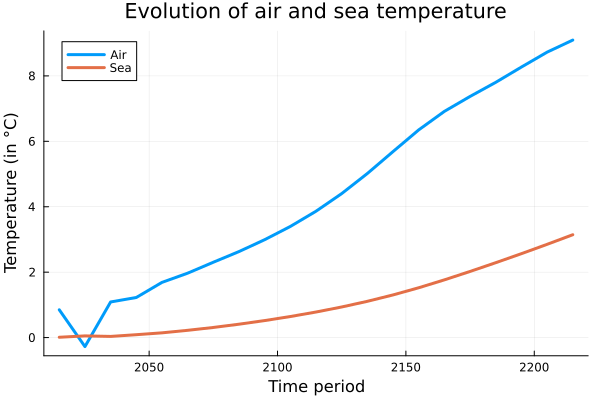

In [24]:
# Evolution of air and sea temperature plot
period = range(start_year,start_year+ 10*hor,length=length(T))

plot(period, [T[:] TL[:]], title="Evolution of air and sea temperature", label=["Air" "Sea"], linewidth=3)
xlabel!("Time period")
ylabel!("Temperature (in °C)")
#savefig("temperatures.png") 


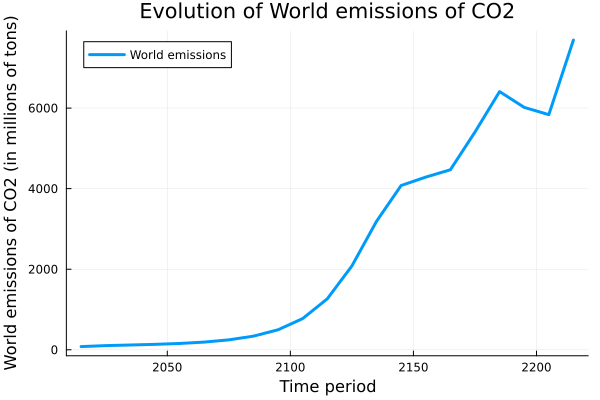

In [25]:
#Evolution of World emissions of CO2 plot
period = range(start_year,start_year+ 10*hor,length=length(MS))

plot(period, MS[:], title="Evolution of World emissions of CO2", label="World emissions", linewidth=3)
xlabel!("Time period")
ylabel!("World emissions of CO2 (in millions of tons)")
#savefig("world_emissions.png") 


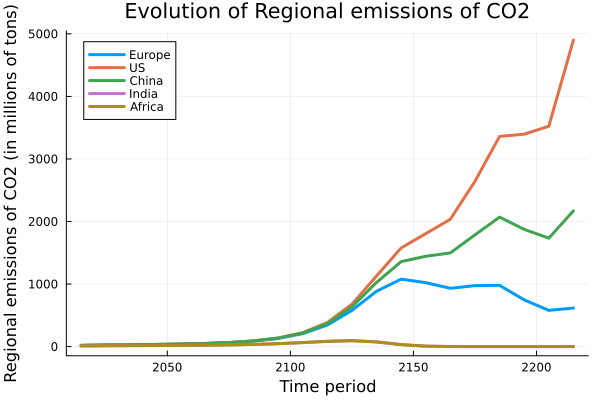

In [26]:
#Evolution of Regional emissions of CO2 plot
period = range(start_year,start_year+ 10*hor,length=size(M,2))

plot(period, [M[1,:] M[2,:] M[3,:] M[4,:] M[5,:]], title="Evolution of Regional emissions of CO2", label=["Europe" "US" "China" "India" "Africa"], linewidth=3)
xlabel!("Time period")
ylabel!("Regional emissions of CO2 (in millions of tons)")
#savefig("regional_emissions.png") 


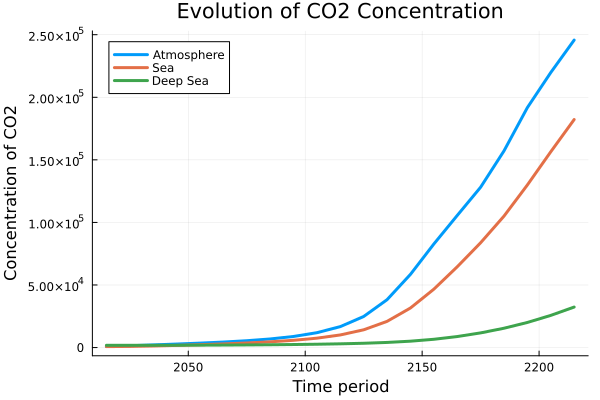

In [27]:
# Evolution of CO2 Concentration plot
period = range(start_year,start_year+ 10*hor,length=size(M,2))

plot(period, [S[:] SU[:] SL[:]], title="Evolution of CO2 Concentration", label=["Atmosphere" "Sea" "Deep Sea"], linewidth=3)
xlabel!("Time period")
ylabel!("Concentration of CO2")
#savefig("CO2_concentration.png") 

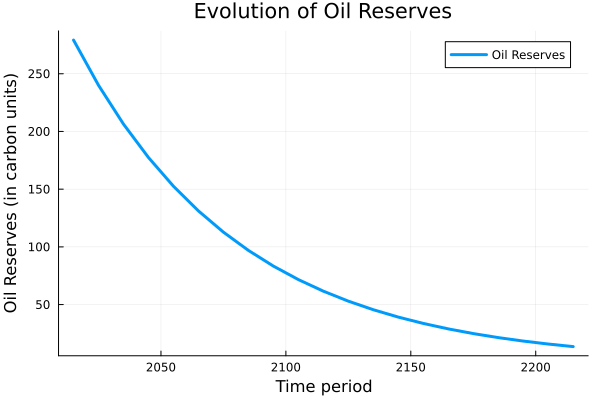

In [28]:
#Evolution of Oil Reserves plot
period = range(start_year,start_year+ 10*hor,length=length(R))

plot(period, R[:], title="Evolution of Oil Reserves", label="Oil Reserves", linewidth=3)
xlabel!("Time period")
ylabel!("Oil Reserves (in carbon units)")
#savefig("Oil_Reserves.png") 

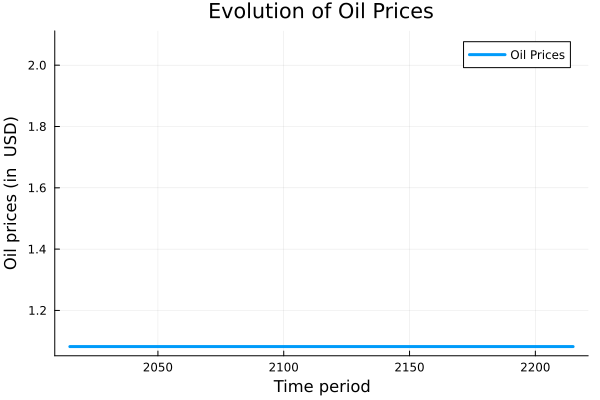

In [29]:
#Evolution of Oil Prices plot
period = range(start_year,start_year+ 10*hor,length=length(p1))

plot(period, p1[:], title="Evolution of Oil Prices", label="Oil Prices", linewidth=3)
xlabel!("Time period")
ylabel!("Oil prices (in  USD)")
#savefig("Oil_prices.png") 

In [14]:
# Exercise 5: 
# To play around with the taxes go to module of TAX RATES and change the tax rates as the pset says. All the code should run accordingly with graphs and new taxes :)

# Question 6:

Does this model satisfy the CCR property? Discuss how you would test it or show it graphically and implement it.

Solution: We use equation (21) from the lecture notes to calculate CCR for a given t (i.e. t=1). If the variance of CCR is small, it is implied that CCR will be constant over time. We can also check the values of CCR or plot the series.

In [15]:
# Exercise 6 CCR

t=1;
for n=1:hor
CCR[n]=(T[t+n]-T[t])/sum(MS[t:t+n-1]);
end

if var(CCR)>1
    println("The CCR property doesn't seem to hold since the variance is too big.")
else
    println("The CCR property seems to hold, since the variance is small.")
end

# Alternitavely, we can check whether the CCR VECTOR is relatively constant over time.
#println(CCR)

The CCR property seems to hold, since the variance is small.
[-0.01420311506119362 0.001306091533687967 0.0012442154372712389 0.001917113768398646 0.00188446781422824 0.0018513630828507876 0.0017253086595208978 0.0015639699093208724 0.0013644814958937456 0.0011406129063833478 0.0009091612816978231 0.0006958605779732359 0.0005271179462638703 0.0004149139800276938 0.0003458026069039509 0.00029633357660035375 0.0002536453688684963 0.00021939308544951483 0.00019768366640273113 0.00018050797661152166]


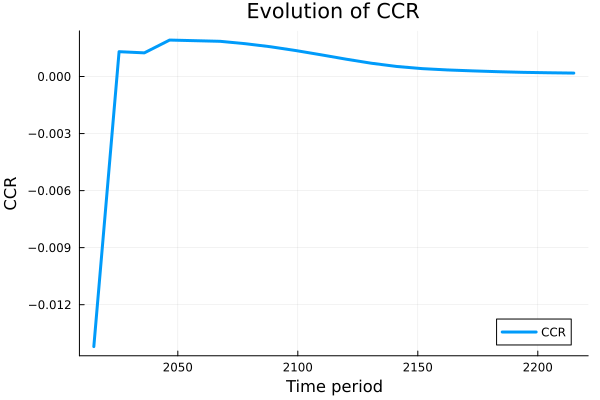

In [16]:
#Evolution of CCR plot
period = range(start_year,start_year+ 10*hor,length=length(CCR))

plot(period, CCR[:], title="Evolution of CCR", label="CCR", linewidth=3)
xlabel!("Time period")
ylabel!("CCR")
#savefig("CCR.png") 